centroid of man.wav is 4024
energy of  man.wav is 266401
sampling rate  48000 
---------------------------------------


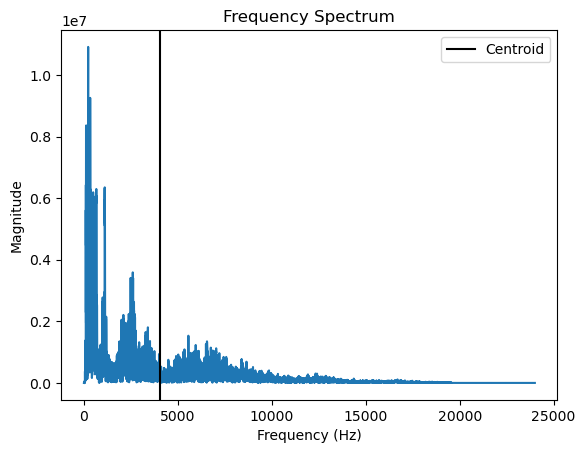

centroid of women2.wav is 2706
energy of  women2.wav is 205975
sampling rate  44100 
---------------------------------------


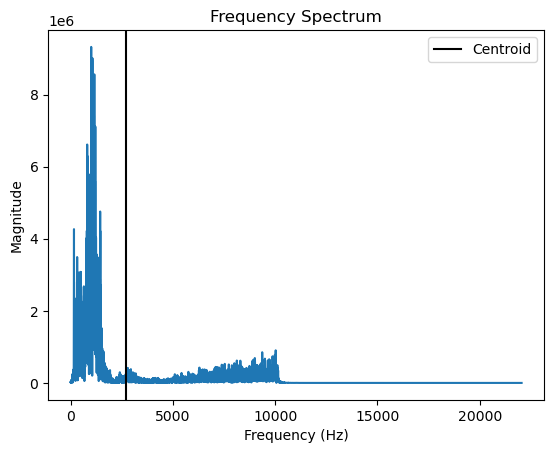

In [20]:
import matplotlib.pyplot as plt 
from scipy.io import wavfile
import numpy as np

records=["man.wav","women2.wav"]

for i in records:
    sr, data = wavfile.read(i)
    if data.ndim > 1:  
                data = data.mean(axis=1)
                record_array,sampling= data.astype(np.float32), sr


    frequencies=np.fft.fft(record_array)
    frequency_at_each_samples=np.fft.fftfreq(len(frequencies),1/sr)
    magnitude=np.abs(frequencies)
    positive_mask = frequency_at_each_samples > 0 
    pos_freqs = frequency_at_each_samples[positive_mask]
    pos_magnitude = magnitude[positive_mask]
    
    centroid=np.sum(pos_freqs*pos_magnitude)/np.sum(pos_magnitude)
    mean_of_magnitude=np.mean(pos_magnitude)

    print(f"centroid of {i} is {int(centroid)}")
    print(f"energy of  {i} is {int(mean_of_magnitude)}")
    print(f"sampling rate  {sr} ")

    print("---------------------------------------")

    

    plt.plot(pos_freqs, pos_magnitude)
    plt.axvline(centroid, color='black',  label='Centroid')
    plt.legend()
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()






   



centroid of women is less than men !!


1 trimming silence 
2 resampling 
3 normalization
4 padding or truncating for ML 

# scalling and  trimming

In [ ]:
# scalling and  trimming
def log_scaling(pos_magnitude):
    E=1e-6
    magnitude_in_dB=20*np.log10(pos_magnitude+E)
    return magnitude_in_dB

def cleaned_freq(magnitude_in_dB,frequencies):
    cleaned_freq=[f for m,f in zip(magnitude_in_dB,frequencies) if m >-40]
    cleaned_mag=[m for m,f in zip(magnitude_in_dB,frequencies) if m >-40]

    return np.array(cleaned_freq), np.array(cleaned_mag)


# resampling 

In [16]:
import librosa
import soundfile as sf

def resample_audio_file(input_path, output_path, target_rate=16000):
    data, sr = librosa.load(input_path, sr=None)
    if data.ndim > 1:  
                data = data.mean(axis=1)

    if sr != target_rate:
        data_resampled = librosa.resample(data, orig_sr=sr, target_sr=target_rate)
    else:
        data_resampled = data

    sf.write(output_path, data_resampled, target_rate)
    return data_resampled, target_rate

    


# extract frequencies

In [19]:
def extract_frequencies(record):
      frequencies=np.fft.fft(record)
      frequency_at_each_samples=np.fft.fftfreq(len(frequencies),1/16000)
      magnitude=np.abs(frequencies)
      positive_mask = frequency_at_each_samples >= 0
      pos_freqs = frequency_at_each_samples[positive_mask]
      pos_magnitude = magnitude[positive_mask]
      return pos_freqs,pos_magnitude

# Spectral features 

In [20]:
def extract_centroid(magnitude,frequency):
        centroid=np.sum(frequency*magnitude)/np.sum(magnitude)
        return centroid


# measure the spread of frequencies around the centroid > women tends to spread more 
def extract_band_width(frequencies,cintroid,magnitude):
    sum=0
    for f,m in zip(frequencies,magnitude):
        sum+=(f-cintroid)**2 *(m)
    band_width=np.sqrt(sum)
    return band_width


# iam searching for specific frequency where the most of energy is below it 
# men will have a lower frequency than women 
def roll_off(frequencies,magnitudes,threshold=.85):
    t_energy=np.sum(magnitudes)
    cumulative_sum=np.cumsum(magnitudes)
    index_roll=np.where(cumulative_sum >= threshold * t_energy)
    roll_off=frequencies[index_roll]
    return roll_off





# YIN algorithm


https://github.com/michelebersani/YIN_Pitch_Detector/blob/master/2002_JASA_YIN.pdf

In [ ]:
def auto_correlation_fixed_w_step_1(signal,n_lags_range,window_size):
     values_at_different_lags=[] 
     for lag in n_lags_range: 
        r_t=0
        for i in range (1,window_size): 
            r_t+=signal[i]*signal[i+lag] 
        values_at_different_lags.append(r_t)
        max_index = values_at_different_lags.index(max(values_at_different_lags)) 
        best_lag = n_lags_range[max_index] 
        f0=16000/best_lag 
        return f0
     

#men 75-150
# women 150-300


def number_of_samples_at_each_window():
    number_of_samples=16000/75  # 213 to complete 1 peroid 
    final_number=number_of_samples*2 # sugsted to be 450
    return final_number


def number_of_windows(record_time,n_samples):
    n_windows=(record_time*16000)/n_samples
    return n_windows


'''
if there is a duplicated frequencies >> peak >> and we may not complete full period yet 
so while iam searching for the signal to appear again by searching for a peak that happens as multibly the signal by it self 
>> indication that we start a new peroid >> f0 >> similarity >> a periodic

فإحنا بندور على أقرب نقطة زمنية فيها الإشارة المزاحة تشبه الأصلية بشكل كافي عشان نقول دي بداية دورة جديدة"
'''

#############################################

def difference_function_(signal, window_size, n_lags_range):
    differences = []
    max_lag = max(n_lags_range)
    for lag in n_lags_range:
        d_tau = 0
        for j in range(window_size - lag):  
            diff = signal[j] - signal[j + lag]
            d_tau += diff ** 2
        differences.append(d_tau)
    return differences

"""
Problem 1  Lag at zero: If I start measuring lag from zero the signal will always perfectly correlate with itself
That means I will get a peak at lag = 0 which falsely suggests a fundamental frequency equal to the entire signal length
I thought about skipping lag = 0 but you mentioned that’s not a real solution—and Iشm not sure why

Problem 2  Small lags and false peaks: When the signal is short or contains very short segments  the lag differences between adjacent samples are tiny
So when I compute the D-autocorrelation these small lags can produce low but non-zero values, which might look like valid dips
If there are many closely spaced segments I might end up with multiple false dips—or even an infinite number of them

Problem 3  Formants mimicking periodicity: formants when translated back into the time domain can create repeated wave like structures These repetitions can cause the autocorrelation to show a dip at lag = 0 or nearby
even though theyare not the actual F0 So I might get a false dipه due to formant induced periodicity even if the true fundamental frequency lies in the same region

"""

#-------------------------------------------------------------
# how cumulative mean solve the problem ?
''' 
The first issue we faced was the zero-lag point We realized that simply skipping lag = 0 isn’t practical
because partial repetitions can occur inside the signal due to formants or small fluctuations
So instead of ignoring it we decided to assign it a fixed value of 1.
Why not a value smaller than zero? Because we don’t want the algorithm to be pulled toward small 
values—it would mistakenly treat lag = 0 as the pitch
(Why not a large value? That would distort the curve and interfere with the thresholding we'll apply later. So we chose 1—a neutral value that neither attracts the algorithm nor disrupts the curve’s shape.)

Now for the other two problems The signal often contains many small dips close together
 which leads to false pitch candidates. To solve this we needed a method that doesn’t just look at each dip in isolation, (but considers its relationship to the previous context)
So if a dip is significantly lower than the cumulative mean of the previous values, it’s likely a true pitch. 
But if it’s close to the cumulative mean, it’s probably just a formant or a weak signal—like two similar signals appearing back-to-back.

why c_mean not mean ? cuase we want to see how each samples contribute over a diffrent  delays not the over all contribution 
'''


#The cumulative mean is supposed to take a sequence of values the first index in the array corresponds to lag zero which is basically each value minus itself squaredThe second entry corresponds to lag one and so on 
def cumulative_mean_step_3(diffrences): 
    final_array_of_cumulative= np.zeros_like(diffrences)
    final_array_of_cumulative[0] = 1  # problem 1

    cumulative_sum = 0.0
    for tau in range(1, len(diffrences)):
        cumulative_sum += diffrences[tau]
        mean = cumulative_sum / tau
        final_array_of_cumulative[tau] = diffrences[tau] / mean if mean != 0 else 0  

    return final_array_of_cumulative



#####################################################

'''
Suppose we have a window that contains purely noise
The problem arises when there's no actual periodicity in the signal but we still compute 
the  difference function At lag 1 or lag 2 we might observe a dip—not because there's a true period
but simply because the cumulative mean is low while the rest of the values are high There are no other dips
in the function, which is a strong indicator that the signal is noise and doesn't contain a fundamental frequency
However if we rely solely on the cumulative mean and stop here the algorithm will automatically select lag 1 
as the fundamental frequency—which is incorrect , so i think there is 2 solution one is 
the threshold but why we dont skip the small lags ?
 
**** frist lag lower than threshold 
**** nothing is lower than 0.1 > noise > no > f0
'''
def threshold_step4(cumulative_array, sampling_rate=16000):
    lag = None
    for i in range(len(cumulative_array)):
        if cumulative_array[i] < 0.1:
            lag = i
            break
    if lag is not None and lag != 0:
        f0 = sampling_rate / lag
    else:
        f0 = 0  
    return f0

#################################################################
'''
The first question we should ask is: Why a parabola? And why do we need it in the first place?

We need it because we're working with lag values that are integers
and the sampling rate is also an integer So when we compute the fundamental frequency as sampling_rate / lag
we end up with a discrete frequency estimate—which isn't always accurate.
In reality the true frequency might be something like 200.5 Hz, not exactly 200 or 201. So what do we do?

It depends on what we need: we're trying to estimate the location of a dip or peak,
which might lie between two integer lag values. That means we need:

The central point (the one we initially selected),
One point before it (to open the range lower),
And one point after it (to open the range higher).

This gives us a local window around the dip,
 and we want to fit a curve to these three points to estimate the true minimum.

The most suitable function to fit three points is a quadratic function 
and that’s why we use it. Plus, the shape of the dip or peak in the CMNDF is often naturally close to a parabolic curvso it’s a good approximation both mathematically and perceptually.
'''

def parabolic_interpolation(cumulative_array, lag):
    if lag <= 0 or lag >= len(cumulative_array) - 1:
        return float(lag)  
    y1 = cumulative_array[lag - 1]
    y2 = cumulative_array[lag]
    y3 = cumulative_array[lag + 1]

    denominator = y1 - 2 * y2 + y3
    if denominator == 0:
        return float(lag)  
    delta = 0.5 * (y1 - y3) / denominator
    refined_lag = lag + delta
    return refined_lag




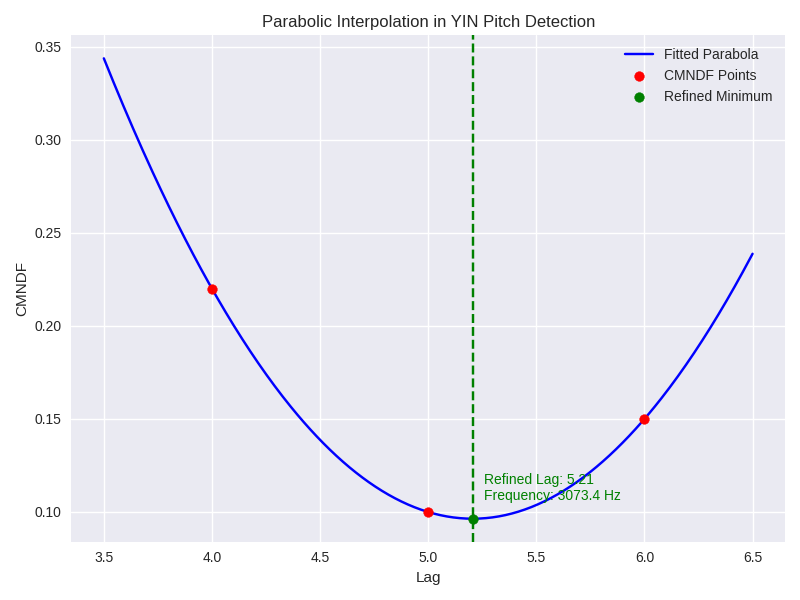

# pitch features

In [22]:
import numpy as np

def extract_pitch_features(signal, window_size=640, hop_size=320, sr=16000):
    f0_values = []

    for start in range(0, len(signal) - window_size, hop_size):
        frame = signal[start:start + window_size]
        n_lags_range = range(int(sr/300), int(sr/75))  # [53, 213] عند sr=16kHz
        diffs = difference_function_(frame, window_size, n_lags_range)
        cmndf = cumulative_mean_step_3(diffs)
        lag = None
        for i in range(1, len(cmndf)):
            if cmndf[i] < 0.1:
                lag = i
                break

        if lag is None:
            f0 = 0
        else:
            refined_lag = parabolic_interpolation(cmndf, lag)
            f0 = sr / refined_lag if refined_lag > 0 else 0

        f0_values.append(f0)

    f0_values = np.array(f0_values)
    voiced = f0_values[f0_values > 0]  # ignore unvoiced

    if len(voiced) == 0:
        return {
            "f0_mean": 0,
            "f0_median": 0,
            "f0_std": 0,
            "f0_min": 0,
            "f0_max": 0,
            "f0_range": 0,
            "jitter": 0,
            "voiced_ratio": 0
        }

    features = {
        "f0_mean": np.mean(voiced),
        "f0_median": np.median(voiced),
        "f0_std": np.std(voiced),
        "f0_min": np.min(voiced),
        "f0_max": np.max(voiced),
        "f0_range": np.max(voiced) - np.min(voiced),

        "jitter": np.std(np.diff(voiced)) / np.mean(voiced) if len(voiced) > 1 else 0,
        "voiced_ratio": len(voiced) / len(f0_values)
    }

    return features


 # normalization vs log sccalling 
 log scalling is like a better representation for the signal >> reducing the difference between sampling log(1) log(10)  >> give a chance to lowe magnitude to appear more clear but the difference is still exsited  and may lead to biasing to higher magnitude or giving more attension (weight) so  we need normalization ***no large diffrences that cuase biasing still keap the diffrences but with bounded range** (need to be checked)>> i will choose in max >> signals do not represent normal distribution  


In [32]:
def normalize_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)


# Energy based features 

# RMS
**1-when i use it over a window ? >> detailed information >> fealing >> tone >> loudness changing over time**
**2-over all the whole spectrum >> general information >> couldnot fully depend on it but if it is combined with other features it may help**


step order is very important i think  the order will be 1-(removing low noise (silence) and high noise >> trimming log scalling )

2- normalization >> if i will use ml model to not bias to higher magnitude 
3-resampling as we will only keep the magnitude from (0 to 8k)
4- rms 
 
square >> protection from cancelling after log as there is already a negative magnitude>> may have physical representation ?

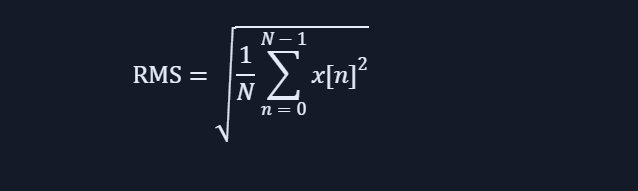

In [23]:
def RMS(magnitude):
    sum=0
    for i in range (len(magnitude)):
        sum+=(magnitude[i])**2
    rms=1/len(magnitude)*sum
    root_rms=np.sqrt(rms)
    return root_rms


# why the frequency spectrum shows a wide range of frequency while the man and women ranges are from 75-300 
formants >> F1 , F2 >> not from 
f0>> indication> men or women >> can not fully depend on it if there is an over lap 
formants >> f1 and f2 >> is higher in women >> give additional information that will help beside f0 

what is the difference between harmonics and formants ??

harmonics > (doubling and tripling from f0 etc same source (larynx))>> this cuased a problem in basic auto correlation >> false peaks before completing full peroid >>(if i remove it will that make the YIN ppreformance better?)


formants > not related to harmonics >> it is cuased by mouth (closing opening etc ) >> مخارج الحروف >> (if i keep it beside f0 this can differeniat between men and women )





In [6]:
def extract_formants_f1_f2():
    pass

# samples creation 
dowenload a long record >> sub records >> arabic , english ,french ,german

In [34]:
import sys
print(sys.executable)


c:\Users\arwah\anaconda3\python.exe


from pydub import AudioSegment
import os

video_path = r"C:\Users\arwah\OneDrive\سطح المكتب\FT_IMPLEMENT\v_women\03.10.2021 - Angela Merkel - Festakt zum Tag der Deutschen Einheit.mp4"

output_folder = r"C:\Users\arwah\OneDrive\سطح المكتب\FT_IMPLEMENT\women_samples\german"
os.makedirs(output_folder, exist_ok=True)

audio = AudioSegment.from_file(video_path)

segment_length = 10 * 1000  # 10 ثواني

for i in range(0, len(audio), segment_length):
    segment = audio[i:i + segment_length]
    segment_path = os.path.join(output_folder, f"segment_{i // 1000}.mp3")
    segment.export(segment_path, format="mp3")


# pip line 

In [34]:
signal, sr = resample_audio_file(
    "man.wav",
    r"C:\Users\arwah\OneDrive\سطح المكتب\FT_IMPLEMENT\man_resampled8.wav"
)

signal = normalize_signal(signal)  

freqs, mags = extract_frequencies(signal)
mags_db = log_scaling(mags)
freqs_clean, mags_clean = cleaned_freq(mags_db, freqs)

# Spectral features
centroid = extract_centroid(mags_clean, freqs_clean)
bandwidth = extract_band_width(freqs_clean, centroid, mags_clean)
roll = roll_off(freqs_clean, mags_clean)
roll_avg = np.mean(roll)  

rms_val = RMS(mags_clean)

# Pitch features
pitch_feats = extract_pitch_features(signal, sr=sr)

print("Spectral:", centroid, bandwidth, roll_avg, rms_val)
print("Pitch:", pitch_feats)


Spectral: 3032.3522192654395 579571.8373008113 6898.900027847397 13.812814598828043
Pitch: {'f0_mean': 165.3251014733661, 'f0_median': 167.9589740272906, 'f0_std': 12.252452526534196, 'f0_min': 143.18899892293138, 'f0_max': 181.36717815504244, 'f0_range': 38.17817923211106, 'jitter': 0.07065504528241878, 'voiced_ratio': 0.20408163265306123}


# Data frame creation 

In [ ]:
import librosa
import pandas as pd 
import os
 
def extract_features_from_file(file_path):
    signal, sr = librosa.load(file_path, sr=None)  
    signal = normalize_signal(signal)

    freqs, mags = extract_frequencies(signal)
    mags_db = log_scaling(mags)
    freqs_clean, mags_clean = cleaned_freq(mags_db, freqs)

    # Spectral
    centroid = extract_centroid(mags_clean, freqs_clean)
    bandwidth = extract_band_width(freqs_clean, centroid, mags_clean)
    roll = roll_off(freqs_clean, mags_clean)
    roll_avg = np.mean(roll)  
    rms_val = RMS(mags_clean)

    spectral_feats = {
        "centroid": centroid,
        "bandwidth": bandwidth,
        "roll_f_avg": roll_avg,
        "RMS": rms_val
    }

    # Pitch
    pitch_feats = extract_pitch_features(signal, sr=sr)

    features = {**spectral_feats, **pitch_feats}
    return features




base_path = r"C:\Users\arwah\OneDrive\سطح المكتب\FT_IMPLEMENT\men_samples"  
all_data = []

for language_folder in os.listdir(base_path):
    language_path = os.path.join(base_path, language_folder)
    
    if os.path.isdir(language_path):
        for file_name in os.listdir(language_path):
            if file_name.endswith(".mp3"):
                file_path = os.path.join(language_path, file_name)
                
                try:
                    features = extract_features_from_file(file_path)
                    features["gender"] = 0  
                    features["language"] = language_folder
                    all_data.append(features)
                
                except Exception as e:
                    print(f"Error in file {file_name}: {e}")


df = pd.DataFrame(all_data)


 


C:\Users\arwah\AppData\Local\Temp\ipykernel_25112\3618932101.py:11: RuntimeWarning: invalid value encountered in sqrt
  band_width=np.sqrt(sum)


KeyboardInterrupt: 

In [40]:
all_data

[{'centroid': -5299.77245328977,
  'bandwidth': nan,
  'roll_f_avg': 4561.428497975684,
  'RMS': 26.853226674291626,
  'f0_mean': 279.95363341990134,
  'f0_median': 168.08911434746224,
  'f0_std': 1735.6634086605447,
  'f0_min': 2.4048063210496875,
  'f0_max': 29400.0,
  'f0_range': 29397.59519367895,
  'jitter': 3.599202604736762,
  'voiced_ratio': 0.616557734204793,
  'gender': 0,
  'language': 'arabic',
  'file_name': 'segment_0.mp3'},
 {'centroid': -8451.252107858387,
  'bandwidth': nan,
  'roll_f_avg': 4391.694150347585,
  'RMS': 25.27218253232049,
  'f0_mean': 185.14677375092788,
  'f0_median': 172.07215639752997,
  'f0_std': 97.85184909767405,
  'f0_min': 19.467093853306437,
  'f0_max': 2197.567624115355,
  'f0_range': 2178.100530262049,
  'jitter': 0.5817245824350292,
  'voiced_ratio': 0.6884531590413944,
  'gender': 0,
  'language': 'arabic',
  'file_name': 'segment_10.mp3'},
 {'centroid': -2338.789399788936,
  'bandwidth': nan,
  'roll_f_avg': 4878.1853991553035,
  'RMS': 27.